# Image generation with Latent Consistency Model and OpenVINO

LCMs: The next generation of generative models after Latent Diffusion Models (LDMs). 
Latent Diffusion models (LDMs) have achieved remarkable results in synthesizing high-resolution images. However, the iterative sampling is computationally intensive and leads to slow generation.

Inspired by [Consistency Models](https://arxiv.org/abs/2303.01469), [Latent Consistency Models](https://arxiv.org/pdf/2310.04378.pdf) (LCMs) were proposed, enabling swift inference with minimal steps on any pre-trained LDMs, including Stable Diffusion. 
The [Consistency Model (CM) (Song et al., 2023)](https://arxiv.org/abs/2303.01469) is a new family of generative models that enables one-step or few-step generation. The core idea of the CM is to learn the function that maps any points on a trajectory of the PF-ODE (probability flow of [ordinary differential equation](https://en.wikipedia.org/wiki/Ordinary_differential_equation)) to that trajectory’s origin (i.e., the solution of the PF-ODE). By learning consistency mappings that maintain point consistency on ODE-trajectory, these models allow for single-step generation, eliminating the need for computation-intensive iterations. However, CM is constrained to pixel space image generation tasks, making it unsuitable for synthesizing high-resolution images. LCMs adopt a consistency model in the image latent space for generation high-resolution images.  Viewing the guided reverse diffusion process as solving an augmented probability flow ODE (PF-ODE), LCMs are designed to directly predict the solution of such ODE in latent space, mitigating the need for numerous iterations and allowing rapid, high-fidelity sampling. Utilizing image latent space in large-scale diffusion models like Stable Diffusion (SD) has effectively enhanced image generation quality and reduced computational load. The authors of LCMs provide a simple and efficient one-stage guided consistency distillation method named Latent Consistency Distillation (LCD) to distill SD for few-step (2∼4) or even 1-step sampling and propose the SKIPPING-STEP technique to further accelerate the convergence. More details about proposed approach and models can be found in [project page](https://latent-consistency-models.github.io/), [paper](https://arxiv.org/abs/2310.04378) and [original repository](https://github.com/luosiallen/latent-consistency-model).

In this tutorial, we consider how to convert and run LCM using OpenVINO. An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.
### Table of content:
- [Prerequisites](#Prerequisites-Uparrow)
- [Prepare models for OpenVINO format conversion](#Prepare-models-for-OpenVINO-format-conversion-Uparrow)
- [Convert models to OpenVINO format](#Convert-models-to-OpenVINO-format-Uparrow)
    - [Text Encoder](#Text-Encoder-Uparrow)
    - [U-Net](#U-Net-Uparrow)
    - [VAE](#VAE-Uparrow)
- [Prepare inference pipeline](#Prepare-inference-pipeline-Uparrow)
    - [Configure Inference Pipeline](#Configure-Inference-Pipeline-Uparrow)
- [Text-to-image generation](#Text-to-image-generation-Uparrow)
- [Quantization](#Quantization-Uparrow)
    - [Prepare calibration dataset](#Prepare-calibration-dataset-Uparrow)
    - [Run quantization](#Run-quantization-Uparrow)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models-Uparrow)
- [Interactive demo](#Interactive-demo-Uparrow)


## Prerequisites [$\Uparrow$](#Table-of-content:)


In [ ]:
%pip install -q "torch" --index-url https://download.pytorch.org/whl/cpu
%pip install -q "openvino>=2023.1.0" transformers "diffusers>=0.21.4" pillow gradio nncf datasets

## Prepare models for OpenVINO format conversion [$\Uparrow$](#Table-of-content:)

In this tutorial we will use [LCM_Dreamshaper_v7](https://huggingface.co/SimianLuo/LCM_Dreamshaper_v7) from [HuggingFace hub](https://huggingface.co/). This model distilled from [Dreamshaper v7](https://huggingface.co/Lykon/dreamshaper-7) fine-tune of [Stable-Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) using Latent Consistency Distillation (LCD) approach discussed above. This model is also integrated into [Diffusers](https://huggingface.co/docs/diffusers/index) library. 🤗 Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules. This allows us to compare running original Stable Diffusion (from this [notebook](../225-stable-diffusion-text-to-image)) and distilled using LCD. The distillation approach efficiently converts a pre-trained guided diffusion model into a latent consistency model by solving an augmented PF-ODE.

For starting work with LCM, we should instantiate generation pipeline first. `DiffusionPipeline.from_pretrained` method download all pipeline components for LCM and configure them. This model uses custom inference pipeline stored as part of model repository, we also should provide which module should be loaded for initialization using `custom_pipeline` argument and revision for it.

In [ ]:
import gc
import warnings
from pathlib import Path
from diffusers import DiffusionPipeline


warnings.filterwarnings("ignore")

TEXT_ENCODER_OV_PATH = Path("model/text_encoder.xml")
UNET_OV_PATH = Path("model/unet.xml")
VAE_DECODER_OV_PATH = Path("model/vae_decoder.xml")


def load_orginal_pytorch_pipeline_componets(skip_models=False):
    pipe = DiffusionPipeline.from_pretrained(
        "SimianLuo/LCM_Dreamshaper_v7",
        custom_pipeline="latent_consistency_txt2img",
        custom_revision="main",
    )
    scheduler = pipe.scheduler
    tokenizer = pipe.tokenizer
    feature_extractor = pipe.feature_extractor
    safety_checker = pipe.safety_checker
    text_encoder, unet, vae = None, None, None
    if not skip_models:
        text_encoder = pipe.text_encoder
        text_encoder.eval()
        unet = pipe.unet
        unet.eval()
        vae = pipe.vae
        vae.eval()
    del pipe
    gc.collect()
    return (
        scheduler,
        tokenizer,
        feature_extractor,
        safety_checker,
        text_encoder,
        unet,
        vae,
    )

In [3]:
skip_conversion = (
    TEXT_ENCODER_OV_PATH.exists()
    and UNET_OV_PATH.exists()
    and VAE_DECODER_OV_PATH.exists()
)

(
    scheduler,
    tokenizer,
    feature_extractor,
    safety_checker,
    text_encoder,
    unet,
    vae,
) = load_orginal_pytorch_pipeline_componets(skip_conversion)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Convert models to OpenVINO format [$\Uparrow$](#Table-of-content:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


Like original Stable Diffusion pipeline, the LCM pipeline consists of three important parts:

* Text Encoder to create condition to generate an image from a text prompt.
* U-Net for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

Let us convert each part:


### Text Encoder [$\Uparrow$](#Table-of-content:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of the text encoder is the tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - Pooled output for whole model hidden states.

In [4]:
import torch
import openvino as ov


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def convert_encoder(text_encoder: torch.nn.Module, ir_path: Path):
    """
    Convert Text Encoder mode.
    Function accepts text encoder model, and prepares example inputs for conversion,
    Parameters:
        text_encoder (torch.nn.Module): text_encoder model from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()

    # disable gradients calculation for reducing memory consumption
    with torch.no_grad():
        # Export model to IR format
        ov_model = ov.convert_model(
            text_encoder,
            example_input=input_ids,
            input=[
                (-1, 77),
            ],
        )
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect()
    print(f"Text Encoder successfully converted to IR and saved to {ir_path}")


if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from model/text_encoder.xml


0

### U-Net [$\Uparrow$](#Table-of-content:)
U-Net model, similar to Stable Diffusion UNet model, has four inputs:

* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.
* `timestep_cond` - timestep condition for generation. This input is not present in original Stable Diffusion U-Net model and introduced by LCM for improving generation quality using Classifier-Free Guidance. [Classifier-free guidance (CFG)](https://arxiv.org/abs/2207.12598) is crucial for synthesizing high-quality text-aligned images in Stable Diffusion, because it controls how similar the generated image will be to the prompt. In Latent Consistency Models, CFG serves as augmentation parameter for PF-ODE.

Model predicts the `sample` state for the next step.

In [5]:
def convert_unet(unet: torch.nn.Module, ir_path: Path):
    """
    Convert U-net model to IR format.
    Function accepts unet model, prepares example inputs for conversion,
    Parameters:
        unet (StableDiffusionPipeline): unet from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    # prepare inputs
    dummy_inputs = {
        "sample": torch.randn((1, 4, 64, 64)),
        "timestep": torch.ones([1]).to(torch.float32),
        "encoder_hidden_states": torch.randn((1, 77, 768)),
        "timestep_cond": torch.randn((1, 256)),
    }
    unet.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=dummy_inputs)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    gc.collect()
    print(f"Unet successfully converted to IR and saved to {ir_path}")


if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
else:
    print(f"Unet will be loaded from {UNET_OV_PATH}")
del unet
gc.collect()

Unet will be loaded from model/unet.xml


0

### VAE [$\Uparrow$](#Table-of-content:)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for text-to-image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

In our inference pipeline, we will not use VAE encoder part and skip its conversion for reducing memory consumption. The process of conversion VAE encoder, can be found in Stable Diffusion notebook.

In [6]:
def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for decoding to IR format.
    Function accepts vae model, creates wrapper class for export only necessary for inference part,
    prepares example inputs for conversion,
    Parameters:
        vae (torch.nn.Module): VAE model frm StableDiffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """

    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f"VAE decoder successfully converted to IR and saved to {ir_path}")


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae
gc.collect()

VAE decoder will be loaded from model/vae_decoder.xml


0

## Prepare inference pipeline [$\Uparrow$](#Table-of-content:)

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![lcm-pipeline](https://user-images.githubusercontent.com/29454499/277402235-079bacfb-3b6d-424b-8d47-5ddf601e1639.png)

The pipeline takes a latent image representation and a text prompt is transformed to text embedding via CLIP's text encoder as an input. The initial latent image representation generated using random noise generator. In difference, with original Stable Diffusion pipeline, LCM also uses guidance scale for getting timestep conditional embeddings as input for diffusion process, while in Stable Diffusion, it used for scaling output latents.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. LCM introduces own scheduling algorithm that extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with non-Markovian guidance.
The *denoising* process is repeated given number of times (by default 50 in original SD pipeline, but for LCM small number of steps required ~2-8) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

In [7]:
from typing import Union, Optional, Any, List, Dict
from transformers import CLIPTokenizer, CLIPImageProcessor
from diffusers.pipelines.stable_diffusion.safety_checker import (
    StableDiffusionSafetyChecker,
)
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.image_processor import VaeImageProcessor


class LatentConsistencyModelPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: ov.Model,
        text_encoder: ov.Model,
        tokenizer: CLIPTokenizer,
        unet: ov.Model,
        scheduler: None,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPImageProcessor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()
        self.vae_decoder = vae_decoder
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.register_to_config(unet=unet)
        self.scheduler = scheduler
        self.safety_checker = safety_checker
        self.feature_extractor = feature_extractor
        self.vae_scale_factor = 2**3
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)

    def _encode_prompt(
        self,
        prompt,
        num_images_per_prompt,
        prompt_embeds: None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.
        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
        """

        if prompt_embeds is None:

            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(
                prompt, padding="longest", return_tensors="pt"
            ).input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[
                -1
            ] and not torch.equal(text_input_ids, untruncated_ids):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

            prompt_embeds = self.text_encoder(text_input_ids, share_inputs=True, share_outputs=True)
            prompt_embeds = torch.from_numpy(prompt_embeds[0])

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(
            bs_embed * num_images_per_prompt, seq_len, -1
        )

        # Don't need to get uncond prompt embedding because of LCM Guided Distillation
        return prompt_embeds

    def run_safety_checker(self, image, dtype):
        if self.safety_checker is None:
            has_nsfw_concept = None
        else:
            if torch.is_tensor(image):
                feature_extractor_input = self.image_processor.postprocess(
                    image, output_type="pil"
                )
            else:
                feature_extractor_input = self.image_processor.numpy_to_pil(image)
            safety_checker_input = self.feature_extractor(
                feature_extractor_input, return_tensors="pt"
            )
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        return image, has_nsfw_concept

    def prepare_latents(
        self, batch_size, num_channels_latents, height, width, dtype, latents=None
    ):
        shape = (
            batch_size,
            num_channels_latents,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if latents is None:
            latents = torch.randn(shape, dtype=dtype)
        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def get_w_embedding(self, w, embedding_dim=512, dtype=torch.float32):
        """
        see https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298
        Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        dtype: data type of the generated embeddings
        Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        guidance_scale: float = 7.5,
        num_images_per_prompt: Optional[int] = 1,
        latents: Optional[torch.FloatTensor] = None,
        num_inference_steps: int = 4,
        lcm_origin_steps: int = 50,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):

        # 1. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # do_classifier_free_guidance = guidance_scale > 0.0
        # In LCM Implementation:  cfg_noise = noise_cond + cfg_scale * (noise_cond - noise_uncond) , (cfg_scale > 0.0 using CFG)

        # 2. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            num_images_per_prompt,
            prompt_embeds=prompt_embeds,
        )

        # 3. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, lcm_origin_steps)
        timesteps = self.scheduler.timesteps

        # 4. Prepare latent variable
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            latents,
        )

        bs = batch_size * num_images_per_prompt

        # 5. Get Guidance Scale Embedding
        w = torch.tensor(guidance_scale).repeat(bs)
        w_embedding = self.get_w_embedding(w, embedding_dim=256)

        # 6. LCM MultiStep Sampling Loop:
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):

                ts = torch.full((bs,), t, dtype=torch.long)

                # model prediction (v-prediction, eps, x)
                model_pred = self.unet([latents, ts, prompt_embeds, w_embedding],share_inputs=True, share_outputs=True)[0]

                # compute the previous noisy sample x_t -> x_t-1
                latents, denoised = self.scheduler.step(
                    torch.from_numpy(model_pred), i, t, latents, return_dict=False
                )
                progress_bar.update()

        if not output_type == "latent":
            image = torch.from_numpy(self.vae_decoder(denoised / 0.18215, share_inputs=True, share_outputs=True)[0])
            image, has_nsfw_concept = self.run_safety_checker(
                image, prompt_embeds.dtype
            )
        else:
            image = denoised
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(
            image, output_type=output_type, do_denormalize=do_denormalize
        )

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

### Configure Inference Pipeline [$\Uparrow$](#Table-of-content:)
First, you should create instances of OpenVINO Model and compile it using selected device. Select device from dropdown list for running inference using OpenVINO.

In [8]:
core = ov.Core()

import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [9]:
text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)
unet_model = core.compile_model(UNET_OV_PATH, device.value)

ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device.value != "CPU" else {}

vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value, ov_config)

Model tokenizer and scheduler are also important parts of the pipeline. This pipeline is also uses Safety Checker, the filter for detecting that corresponding generated image contains "not-safe-for-work" (nsfw) content. The process of nsfw content detection requires to obtain image embeddings using CLIP model, so additionally feature extractor component should be added in the pipeline. We reuse tokenizer, feature extractor, scheduler and safety checker from original LCM pipeline.

In [10]:
ov_pipe = LatentConsistencyModelPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_decoder=vae_decoder,
    scheduler=scheduler,
    feature_extractor=feature_extractor,
    safety_checker=safety_checker,
)

## Text-to-image generation [$\Uparrow$](#Table-of-content:)
Now, let's see model in action

In [14]:
prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4
torch.manual_seed(1234567)

images = ov_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    lcm_origin_steps=50,
    output_type="pil",
    height=512,
    width=512,
).images

  0%|          | 0/4 [00:00<?, ?it/s]

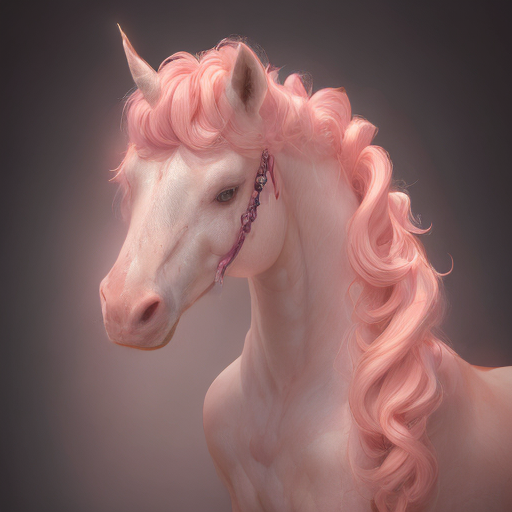

In [15]:
images[0]

Nice. As you can see, the picture has quite a high definition 🔥.

## Quantization [$\Uparrow$](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `LatentConsistencyModelPipeline` structure, UNet used for iterative denoising of input. It means that model runs in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. That is why computation cost and speed of UNet denoising becomes the critical path in the pipeline. Quantizing the rest of the SD pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [16]:
to_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [ ]:
import sys
sys.path.append("../utils")
import skip_kernel_extension
%load_ext skip_kernel_extension

### Prepare calibration dataset [$\Uparrow$](#Table-of-contents:)

We use a portion of [`laion/laion2B-en`](https://huggingface.co/datasets/laion/laion2B-en) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [18]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from transformers import Pipeline
from typing import Any, Dict, List

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(lcm_pipeline: Pipeline, subset_size: int) -> List[Dict]:
    original_unet = lcm_pipeline.unet
    lcm_pipeline.unet = CompiledModelDecorator(original_unet, prob=0.3)

    dataset = datasets.load_dataset("laion/laion2B-en", split="train", streaming=True).shuffle(seed=42)
    lcm_pipeline.set_progress_bar_config(disable=True)

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["TEXT"]
        _ = lcm_pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            lcm_origin_steps=50,
            output_type="pil",
            height=512,
            width=512,
        )
        collected_subset_size = len(lcm_pipeline.unet.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    calibration_dataset = lcm_pipeline.unet.data_cache
    lcm_pipeline.set_progress_bar_config(disable=False)
    lcm_pipeline.unet = original_unet
    return calibration_dataset

In [ ]:
%%skip not $to_quantize.value

import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

UNET_INT8_OV_PATH = Path("model/unet_int8.xml")
if not UNET_INT8_OV_PATH.exists():
    subset_size = 200
    unet_calibration_data = collect_calibration_data(ov_pipe, subset_size=subset_size)

### Run quantization [$\Uparrow$](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope

if UNET_INT8_OV_PATH.exists():
    print("Loading quantized model")
    quantized_unet = core.read_model(UNET_INT8_OV_PATH)
else:
    unet = core.read_model(UNET_OV_PATH)
    quantized_unet = nncf.quantize(
        model=unet,
        subset_size=subset_size,
        preset=nncf.QuantizationPreset.MIXED,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

In [77]:
%%skip not $to_quantize.value

unet_optimized = core.compile_model(UNET_INT8_OV_PATH, device.value)

int8_pipe = LatentConsistencyModelPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_optimized,
    vae_decoder=vae_decoder,
    scheduler=scheduler,
    feature_extractor=feature_extractor,
    safety_checker=None,
)

Let us check predictions with the quantized UNet using the same input data.

  0%|          | 0/4 [00:00<?, ?it/s]

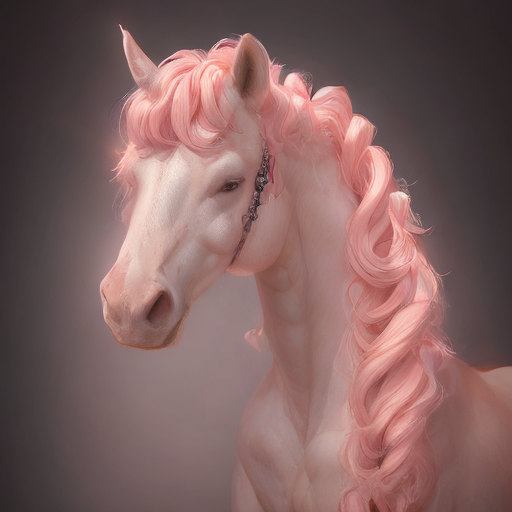

In [22]:
%%skip not $to_quantize.value

from IPython.display import display

prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4
torch.manual_seed(1234567)

images = int8_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    lcm_origin_steps=50,
    output_type="pil",
    height=512,
    width=512,
).images

display(images[0])

### Compare inference time of the FP16 and INT8 models [$\Uparrow$](#Table-of-content:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [26]:
%%skip not $to_quantize.value

import time

validation_size = 10
calibration_dataset = datasets.load_dataset("laion/laion2B-en", split="train", streaming=True).take(validation_size)
validation_data = []
while len(validation_data) < validation_size:
    batch = next(iter(calibration_dataset))
    prompt = batch["TEXT"]
    validation_data.append(prompt)

def calculate_inference_time(pipeline, calibration_dataset):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    for prompt in calibration_dataset:
        start = time.perf_counter()
        _ = pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            lcm_origin_steps=50,
            output_type="pil",
            height=512,
            width=512,
        )
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

Resolving data files:   0%|          | 0/128 [00:00<?, ?it/s]

In [63]:
%%skip not $to_quantize.value

fp_latency = calculate_inference_time(ov_pipe, validation_data)
int8_latency = calculate_inference_time(int8_pipe, validation_data)
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

Performance speed up: 1.307


## Interactive demo [$\Uparrow$](#Table-of-content:)


In [115]:
import random
import gradio as gr
import numpy as np
from functools import partial

MAX_SEED = np.iinfo(np.int32).max

examples = [
    "portrait photo of a girl, photograph, highly detailed face, depth of field, moody light, golden hour,"
    "style by Dan Winters, Russell James, Steve McCurry, centered, extremely detailed, Nikon D850, award winning photography",
    "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k",
    "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "A photo of beautiful mountain with realistic sunset and blue lake, highly detailed, masterpiece",
]


def randomize_seed_fn(seed: int, randomize_seed: bool) -> int:
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
    return seed


MAX_IMAGE_SIZE = 768

def generate(
    pipeline: LatentConsistencyModelPipeline,
    prompt: str,
    seed: int = 0,
    width: int = 512,
    height: int = 512,
    guidance_scale: float = 8.0,
    num_inference_steps: int = 4,
    randomize_seed: bool = False,
    num_images: int = 1,
    progress=gr.Progress(track_tqdm=True),
):
    seed = randomize_seed_fn(seed, randomize_seed)
    torch.manual_seed(seed)
    result = pipeline(
        prompt=prompt,
        width=width,
        height=height,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=num_images,
        lcm_origin_steps=50,
        output_type="pil",
    ).images[0]
    return result, seed

generate_original = partial(generate, ov_pipe)
generate_optimized = partial(generate, int8_pipe)
quantized_model_present = int8_pipe is not None

with gr.Blocks() as demo:
    with gr.Group():
        with gr.Row():
            prompt = gr.Text(
                label="Prompt",
                show_label=False,
                max_lines=1,
                placeholder="Enter your prompt",
                container=False,
            )
        with gr.Row():
            with gr.Column():
                result = gr.Image(label="Result (Original)" if quantized_model_present else "Image", type="pil")
                run_button = gr.Button("Run")
            with gr.Column(visible=quantized_model_present):
                result_optimized = gr.Image(label="Result (Optimized)", type="pil", visible=quantized_model_present)
                run_quantized_button = gr.Button(value="Run quantized", visible=quantized_model_present)

    with gr.Accordion("Advanced options", open=False):
        seed = gr.Slider(
            label="Seed", minimum=0, maximum=MAX_SEED, step=1, value=0, randomize=True
        )
        randomize_seed = gr.Checkbox(label="Randomize seed across runs", value=True)
        with gr.Row():
            width = gr.Slider(
                label="Width",
                minimum=256,
                maximum=MAX_IMAGE_SIZE,
                step=32,
                value=512,
            )
            height = gr.Slider(
                label="Height",
                minimum=256,
                maximum=MAX_IMAGE_SIZE,
                step=32,
                value=512,
            )
        with gr.Row():
            guidance_scale = gr.Slider(
                label="Guidance scale for base",
                minimum=2,
                maximum=14,
                step=0.1,
                value=8.0,
            )
            num_inference_steps = gr.Slider(
                label="Number of inference steps for base",
                minimum=1,
                maximum=8,
                step=1,
                value=4,
            )

    gr.Examples(
        examples=examples,
        inputs=prompt,
        outputs=result,
        cache_examples=False,
    )

    gr.on(
        triggers=[
            prompt.submit,
            run_button.click,
        ],
        fn=generate_original,
        inputs=[
            prompt,
            seed,
            width,
            height,
            guidance_scale,
            num_inference_steps,
            randomize_seed,
        ],
        outputs=[result, seed],
    )

    if quantized_model_present:
        gr.on(
            triggers=[
                prompt.submit,
                run_quantized_button.click,
            ],
            fn=generate_optimized,
            inputs=[
                prompt,
                seed,
                width,
                height,
                guidance_scale,
                num_inference_steps,
                randomize_seed,
            ],
            outputs=[result_optimized, seed],
        )

In [ ]:
demo.queue().launch()